In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML
import BasicTools as BT
import WaveTools as WT
import PlotTools as PT
import FFTTools as FFTT
import OperatorTools as OT
import GridTransferTools as GTT
import SolverTools as ST

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 1000)

In [2]:
# def MakeRotMat(omega, t):
#     t = 0
#     Cosine = lambda k: np.cos(2. * np.pi * k * c * t)
#     Sine = lambda k: np.sin(2. * np.pi * k * c * t)
#     RotMat = lambda k: np.asarray([Cosine(k), Sine(k), -Sine(k), Cosine(k)]).reshape(2, 2)
#     rotMats = [RotMat(k) for k in range(int(nh / 2) + 1)]
#     shift = LA2.block_diag(*rotMats)[1:-1, 1:-1]
#     shift[0, 0] = 0
#     shift[::-1, ::-1][0, 0] = int(nh / 2)
#     return shift

In [3]:
c = 1.
CFL = 1.
nh = 4
cells = [[0, 2], [4, 5]]#, [9]]
omega = BT.Grid(nh)
nt = 20
for cell in cells:
    omega.AddPatch(2, cell)

In [4]:
t, nt = ST.CalcTime(omega, CFL, c, nt = nt)
print(t)

1.25


In [5]:
waves = WT.MakeWaves(omega)
print(waves)

[[ 1.00000000e+00  3.72923229e-01  9.00316316e-01  6.36619772e-01  6.36619772e-01  7.24518620e-01  3.00105439e-01  6.36619772e-01  3.89817183e-17  4.34711172e-01 -1.80063263e-01  2.12206591e-01 -2.12206591e-01  5.32747469e-02 -1.28616617e-01  0.00000000e+00]
 [ 1.00000000e+00  9.00316316e-01  3.72923229e-01  6.36619772e-01 -6.36619772e-01 -3.00105439e-01 -7.24518620e-01 -6.36619772e-01 -1.16945155e-16 -1.80063263e-01  4.34711172e-01  2.12206591e-01  2.12206591e-01  1.28616617e-01 -5.32747469e-02  0.00000000e+00]
 [ 1.00000000e+00  6.36619772e-01 -6.36619772e-01 -6.36619772e-01 -1.16945155e-16  2.12206591e-01  2.12206591e-01  0.00000000e+00 -3.89817183e-17  1.27323954e-01 -1.27323954e-01 -2.12206591e-01 -1.16945155e-16  9.09456818e-02  9.09456818e-02  0.00000000e+00]
 [ 1.00000000e+00 -1.93839179e-01 -9.74495358e-01  3.72923229e-01  9.00316316e-01 -5.23994577e-01 -7.84213304e-01  6.36619772e-01  6.36619772e-01 -7.04194890e-01 -4.70527982e-01  7.24518620e-01  3.00105439e-01 -6.99874143e-

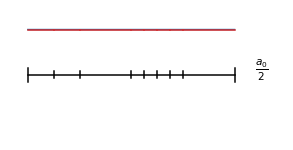

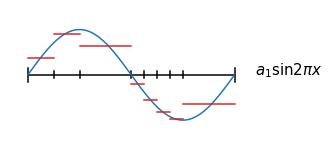

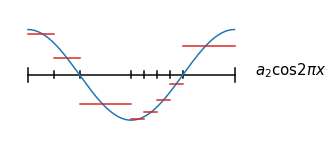

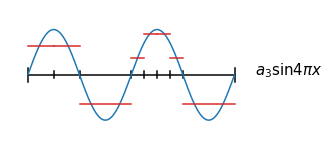

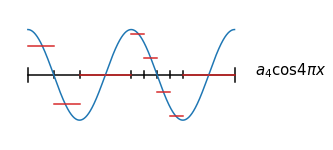

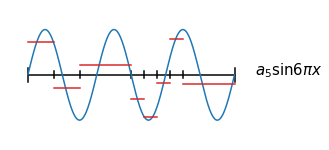

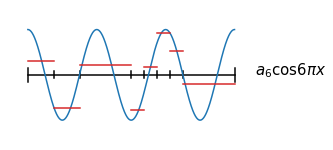

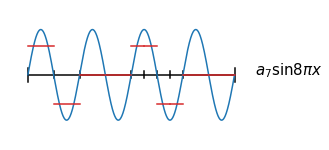

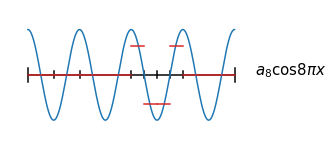

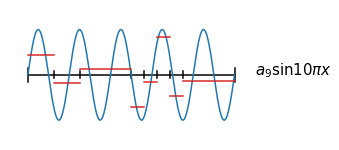

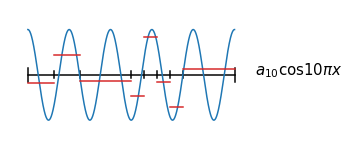

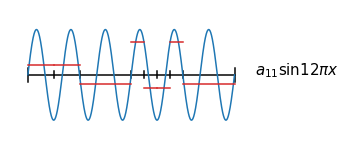

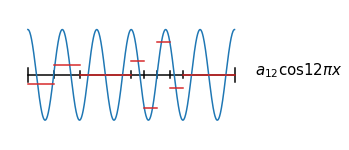

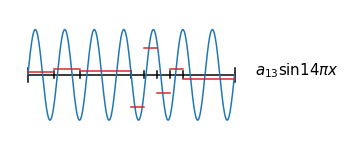

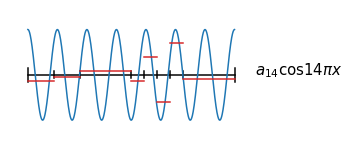

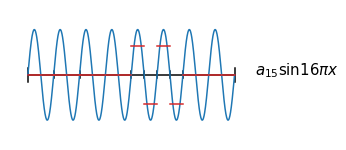

In [6]:
PT.PlotWaves(omega, waves=waves)

nh = 16
[[ 1.          0.37292323  0.90031632  0.63661977  0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 1.          0.90031632  0.37292323  0.63661977  0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 1.          0.63661977 -0.63661977 -0.63661977  0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 1.         -0.19383918 -0.97449536  0.37292323  0.90031632 -0.52399458 -0.7842133   0.63661977  0.63661977 -0.70419489 -0.47052798  0.72451862  0.30010544 -0.69987414 -0.13921362  0.63661977]
 [ 1.         -0.55200728 -0.82613727  0.90031632  0.37292323 -0.92504266  0.18400243  0.63661977 -0.63661977 -0.16522745  0.83065451 -0.30010544 -0.72451862  0.59332465  0.39644686 -0.63661977]
 [ 1.         -0.

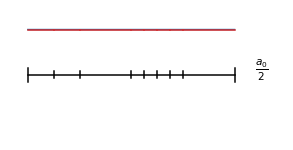

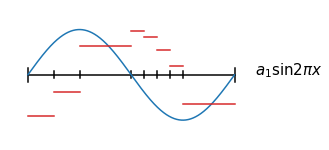

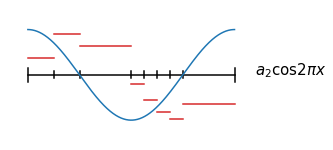

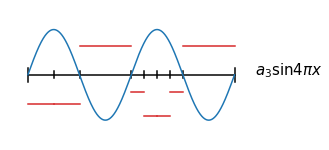

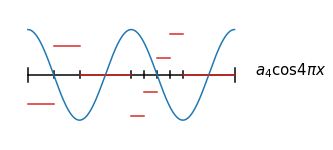

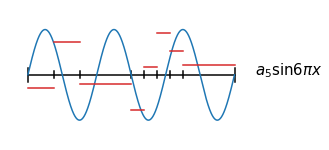

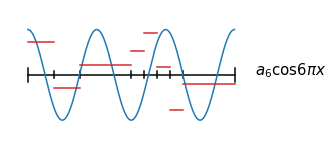

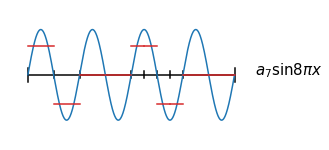

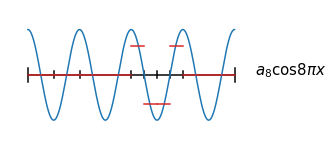

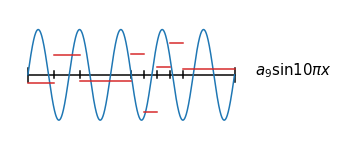

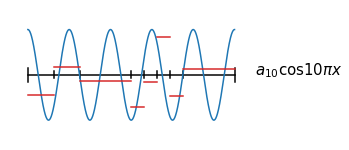

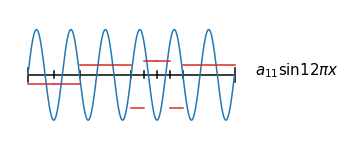

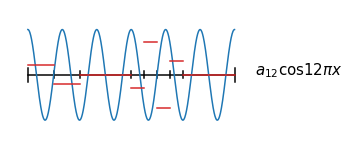

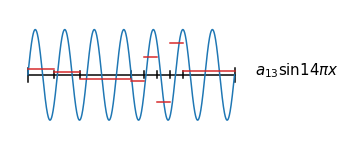

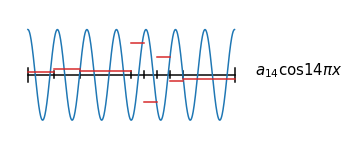

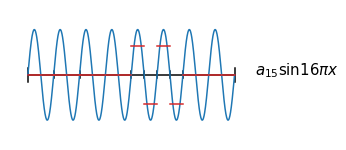

In [9]:
 def PropWaves(omega, waves, c, t):
    nh = omega.nh_max
    nhs = omega.nh
    hs = omega.h
    levels = omega.levels
    refRatios = omega.refRatios
    rotMat = OT.MakeRotMat(omega, c * t)
    backRotMat = rotMat[::-1, ::-1] + 0
    np.fill_diagonal(backRotMat[1:], np.diagonal(backRotMat, offset = 1))
    np.fill_diagonal(backRotMat[:, 1:], -np.diagonal(backRotMat, offset = 1))
    h = 1. / nh
    aliasedWaves = int(nhs[0])
    fineSpots = np.where(hs == h)[0]
    wavesAlias = waves + 0
    wavesAlias[:, :aliasedWaves] = 0
    wavesAlias[fineSpots, :] = 0
    workingWaves = waves - wavesAlias
    propMat = workingWaves @ rotMat
    print('nh =', nh)
    print(workingWaves)
    for q in range(levels):
        nh = nhs[::-1][q + 1]
        print('nh = ', nh)
        h = 1. / nh
        workingWaves = wavesAlias + 0
        fineSpots = np.where(hs != h)[0]
        workingWaves[fineSpots, :] = 0
        propMat = propMat + (workingWaves @ backRotMat)
        wavesAlias = wavesAlias - workingWaves
        print(workingWaves)
    return propMat
propWaves = PropWaves(omega, waves, c, t)
nullspace = OT.FindNullspace(omega, propWaves)
PT.PlotWaves(omega, waves = propWaves)

In [8]:
A = MakeRotMat(omega)
B = A[::-1, ::-1] + 0 # np.roll(A, 1, axis = 0)
np.fill_diagonal(B[1:], np.diagonal(B, offset = 1))
np.fill_diagonal(B[:, 1:], -np.diagonal(B, offset = 1))
C = np.roll(B, 7, axis = 0)
C = np.roll(C, 7, axis = 1)

NameError: name 'MakeRotMat' is not defined

In [ ]:
print('A =\n', A)
print('')
print('B =\n', B)
print('')
print('C =\n', C)
print('')